## Modules


In [1]:
#!pip install -r requirements.txt
import pandas as pd
import json
from tabulate import tabulate
import matplotlib.pyplot as plt


## Load test data

In [2]:
def read_json_to_dataframe(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    df = pd.DataFrame(data)
    
    return df

CHALLENGES_CONFIG = 'challenges_1234.json'
CHALLENGE_21 = '../performance/agentPerformance_challenge_21.json'
CHALLENGE_22 = '../performance/agentPerformance_challenge_22.json'
CHALLENGE_23 = '../performance/agentPerformance_challenge_23.json'
CHALLENGE_24 = '../performance/agentPerformance_challenge_24.json'
CHALLENGE_31 = '../performance/multiagent/agentPerformance_challenge_31.json'
CHALLENGE_32 = '../performance/multiagent/agentPerformance_challenge_32.json'
CHALLENGE_33 = '../performance/multiagent/agentPerformance_challenge_33.json'

environments = read_json_to_dataframe(CHALLENGES_CONFIG)
df21 = read_json_to_dataframe(CHALLENGE_21)
df22 = read_json_to_dataframe(CHALLENGE_22)
df23 = read_json_to_dataframe(CHALLENGE_23)
df24 = read_json_to_dataframe(CHALLENGE_24)
df31 = read_json_to_dataframe(CHALLENGE_31)
df32 = read_json_to_dataframe(CHALLENGE_32)
df33 = read_json_to_dataframe(CHALLENGE_33)

single_agent_tests = pd.concat([df21, df22, df23, df24])
multiagent_tests = pd.concat([df31, df32, df33])

single_agent_tests.drop(['initialScore','finalScore'], axis = 1)
single_agent_tests['activityTime'] = single_agent_tests['activityTime'].apply(lambda x: int(x.split(' ')[0].split(':')[0][1]))
multiagent_tests.drop(['initialScore','finalScore'], axis = 1)
multiagent_tests['activityTime'] = multiagent_tests['activityTime'].apply(lambda x: int(x.split(' ')[0].split(':')[0][1]))

tests_bfs = single_agent_tests[single_agent_tests['moveType'] == 'BFS']
tests_pddl =  single_agent_tests[single_agent_tests['moveType'] == 'PDDL']
multiagent_tests_bfs =  multiagent_tests[multiagent_tests['moveType'] == 'BFS']
multiagent_tests_pddl =  multiagent_tests[multiagent_tests['moveType'] == 'PDDL']
multiagent_tests_pddl_1 =  multiagent_tests[multiagent_tests['moveType'] == 'PDDL_1']

print(f'Environment configs: {len(environments)}')
print(f'PDDL tests: {len(tests_pddl)}')
print(f'BFS tests: {len(tests_bfs)}')
print(f'Multiagent tests:', len(multiagent_tests))
print(f'Multiagent BFS tests: {len(multiagent_tests_bfs)}')
print(f'Multiagent PDDL tests: {len(multiagent_tests_pddl)}')
print(f'Multiagent PDDL_1 tests: {len(multiagent_tests_pddl_1)}')

Environment configs: 4
PDDL tests: 40
BFS tests: 98
Multiagent tests: 32
Multiagent BFS tests: 12
Multiagent PDDL tests: 12
Multiagent PDDL_1 tests: 8


### Single agent - TOP-K performances by Strategy & Challenge

In [3]:
def printTable(df, title='', showIndex=True, limit=10):

    print(title)
    print(tabulate(df[:limit], headers='keys', showindex=showIndex, tablefmt='grid'))

def analyze_challenge_performance(df : pd.DataFrame, strategy):
        grouped = df.groupby('map')
        for name, group in grouped:
            print(f'\n\nMap {name} - Strategy {strategy} Agent performance')
            group['score_per_seconds'] = group['effectiveScore'] / (group['activityTime'] * 60)
            printTable(group.sort_values(by=['effectiveScore','averageTimePerMove'], ascending=False)[:K], f'Top {K} best agent perfomances')

K = 50
analyze_challenge_performance(tests_bfs, 'BFS')
analyze_challenge_performance(tests_pddl, 'PDDL')
printTable(environments)



Map challenge_21 - Strategy BFS Agent performance
Top 50 best agent perfomances
+----+--------------+------------+------------+----------------+-------------------------+-------------+-------------+----------------+----------------------+----------------+--------------+------------------+---------------------+-------------------+-----------------+-------------------+--------------------+---------------+-------------+---------------------+--------------+---------------------+
|    | map          | moveType   | fastPick   |   changingRisk |   adjMovementCostWindow | agentName   | agentID     |   activityTime |   averageTimePerMove |   initialScore |   finalScore |   effectiveScore |   effectiveMovement |   failedMovements |   pickUpActions |   deliveryActions |   parcelsDelivered |   searchCalls |   cacheHits |   onlineSolverCalls |   multiagent |   score_per_seconds |
+====+==============+============+============+================+=========================+=============+=============+

### Multia-agent - TOP-K performances by Strategy & Challenge

In [9]:
def analyze_challenge_performance(df: pd.DataFrame, strategy):
    df = df[df['activityTime'] > 0]
    df['score_per_seconds'] = df['effectiveScore'] / (df['activityTime'] * 60)
    return analyze_team_performance(df)

def analyze_team_performance(df: pd.DataFrame):
    grouped = df.groupby(['teamId', 'map'])
    
    team_performance = grouped.agg(
        total_effectiveScore=pd.NamedAgg(column='effectiveScore', aggfunc='sum'),
        avg_score_per_seconds=pd.NamedAgg(column='score_per_seconds', aggfunc='mean')
    ).reset_index()

    team_performance_sorted = team_performance.sort_values(by='total_effectiveScore', ascending=False)
    
    return team_performance_sorted

team_performance_bfs = analyze_challenge_performance(multiagent_tests_bfs, 'BFS')
team_performance_pddl = analyze_challenge_performance(multiagent_tests_pddl, 'PDDL')
team_performance_pddl_1 = analyze_challenge_performance(multiagent_tests_pddl_1, 'PDDL_1')

printTable(team_performance_bfs, "BFS Team Performance:\n")
printTable(team_performance_pddl, "\nPDDL Team Performance:\n")
printTable(team_performance_pddl_1, "\nPDDL_1 Team Performance:\n")


BFS Team Performance:

+----+----------------+--------------+------------------------+-------------------------+
|    | teamId         | map          |   total_effectiveScore |   avg_score_per_seconds |
+====+================+==============+========================+=========================+
|  2 | Harvester_6135 | challenge_32 |                   2542 |                 7.06111 |
+----+----------------+--------------+------------------------+-------------------------+
|  5 | Harvester_9288 | challenge_32 |                   2084 |                 5.78889 |
+----+----------------+--------------+------------------------+-------------------------+
|  4 | Harvester_9276 | challenge_31 |                   1427 |                 3.96389 |
+----+----------------+--------------+------------------------+-------------------------+
|  1 | Harvester_4041 | challenge_31 |                   1164 |                 3.23333 |
+----+----------------+--------------+------------------------+--------------

## Performance analysis


In [6]:
def plot_grouped_lines(df, group_column, y_column):

    grouped = df.groupby(group_column)
    
    plt.figure(figsize=(10, 6)) 
    for name, group in grouped:

        plt.plot(group.index, group[y_column], label=name)
    
    plt.xlabel('Index') 
    plt.ylabel(y_column) 
    plt.title(f'{y_column} by {group_column}') 
    plt.legend(title=group_column)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

def plot_grouped_bars(df, group_columns, y_column, aggregation='mean'):
    if not isinstance(group_columns, list):
        group_columns = [group_columns]
    
    aggregated_data = df.groupby(group_columns)[y_column].agg(aggregation).reset_index()
    
    aggregated_data['group'] = aggregated_data[group_columns].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    
    plt.figure(figsize=(20, 12))
    plt.bar(aggregated_data['group'], aggregated_data[y_column])

    plt.xlabel(' & '.join(group_columns)) 
    plt.ylabel(y_column) 
    plt.title(f'{aggregation.capitalize()} of {y_column} by {" & ".join(group_columns)}')
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--')
    plt.show()

groups_bfs = tests_bfs.groupby(['moveType', 'fastPick', 'changingRisk', 'adjMovementCostWindow'])
groups_pddl = tests_pddl.groupby(['moveType', 'fastPick', 'changingRisk', 'adjMovementCostWindow'])

print('Single agent tests configurations:\n')
for name, group in groups_bfs:
    print(f"Group: {name} - Count: {len(group)}")

for name, group in groups_pddl:
    print(f"Group: {name} - Count: {len(group)}")


Single agent tests configurations:

Group: ('BFS', False, 0.0, 5000) - Count: 9
Group: ('BFS', False, 0.25, 5000) - Count: 8
Group: ('BFS', False, 0.5, 5000) - Count: 8
Group: ('BFS', False, 0.75, 5000) - Count: 8
Group: ('BFS', False, 1.0, 5000) - Count: 8
Group: ('BFS', True, 0.0, 5000) - Count: 8
Group: ('BFS', True, 0.25, 5000) - Count: 8
Group: ('BFS', True, 0.5, 1000) - Count: 8
Group: ('BFS', True, 0.5, 5000) - Count: 8
Group: ('BFS', True, 0.5, 20000) - Count: 8
Group: ('BFS', True, 0.75, 5000) - Count: 8
Group: ('BFS', True, 1.0, 5000) - Count: 9
Group: ('PDDL', True, 0.0, 1000) - Count: 8
Group: ('PDDL', True, 0.25, 1000) - Count: 8
Group: ('PDDL', True, 0.5, 1000) - Count: 8
Group: ('PDDL', True, 0.75, 1000) - Count: 8
Group: ('PDDL', True, 1.0, 1000) - Count: 8


## Single agent BFS

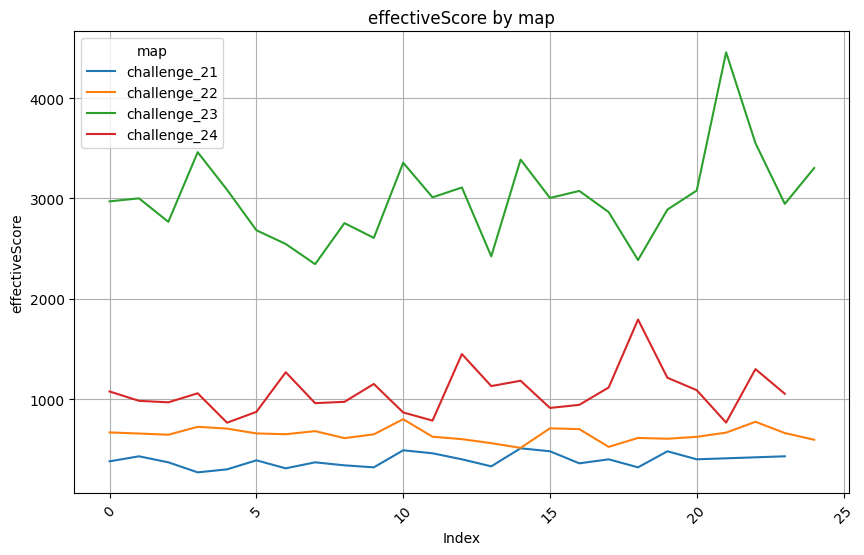

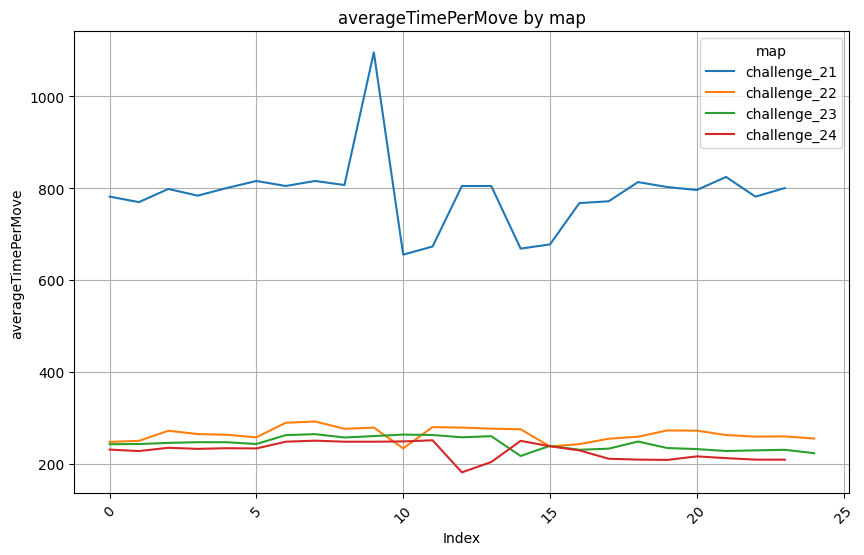

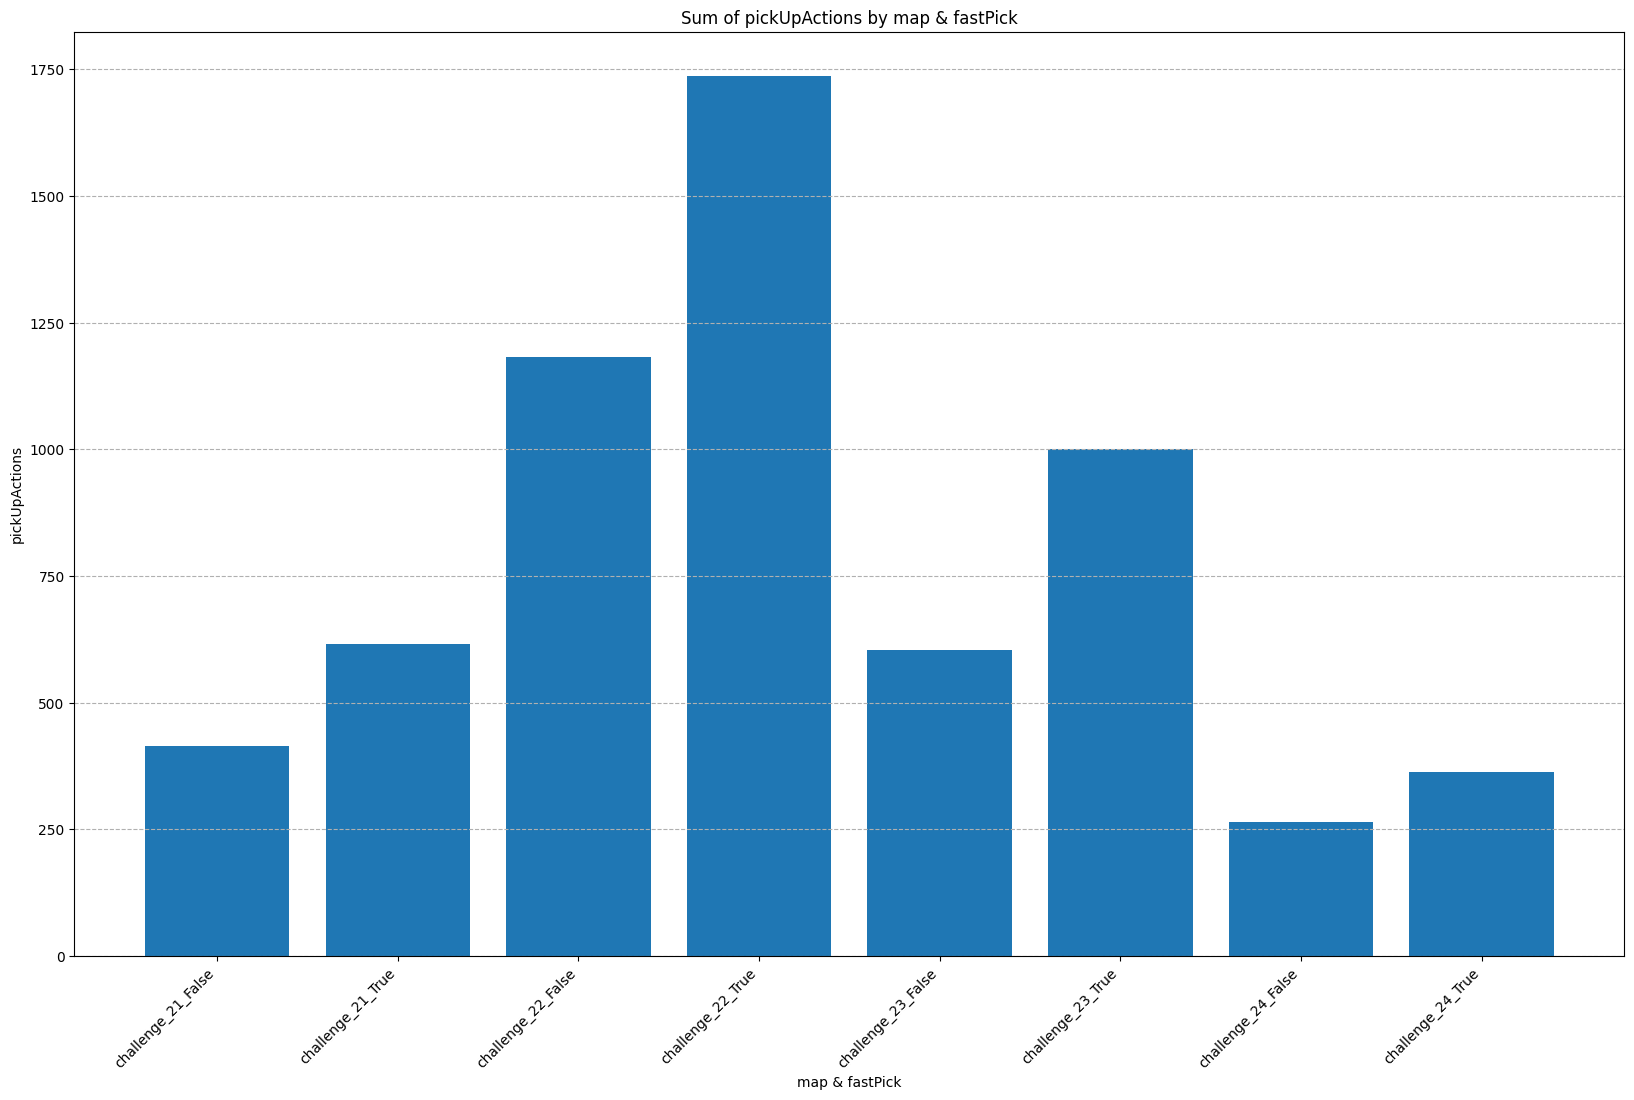

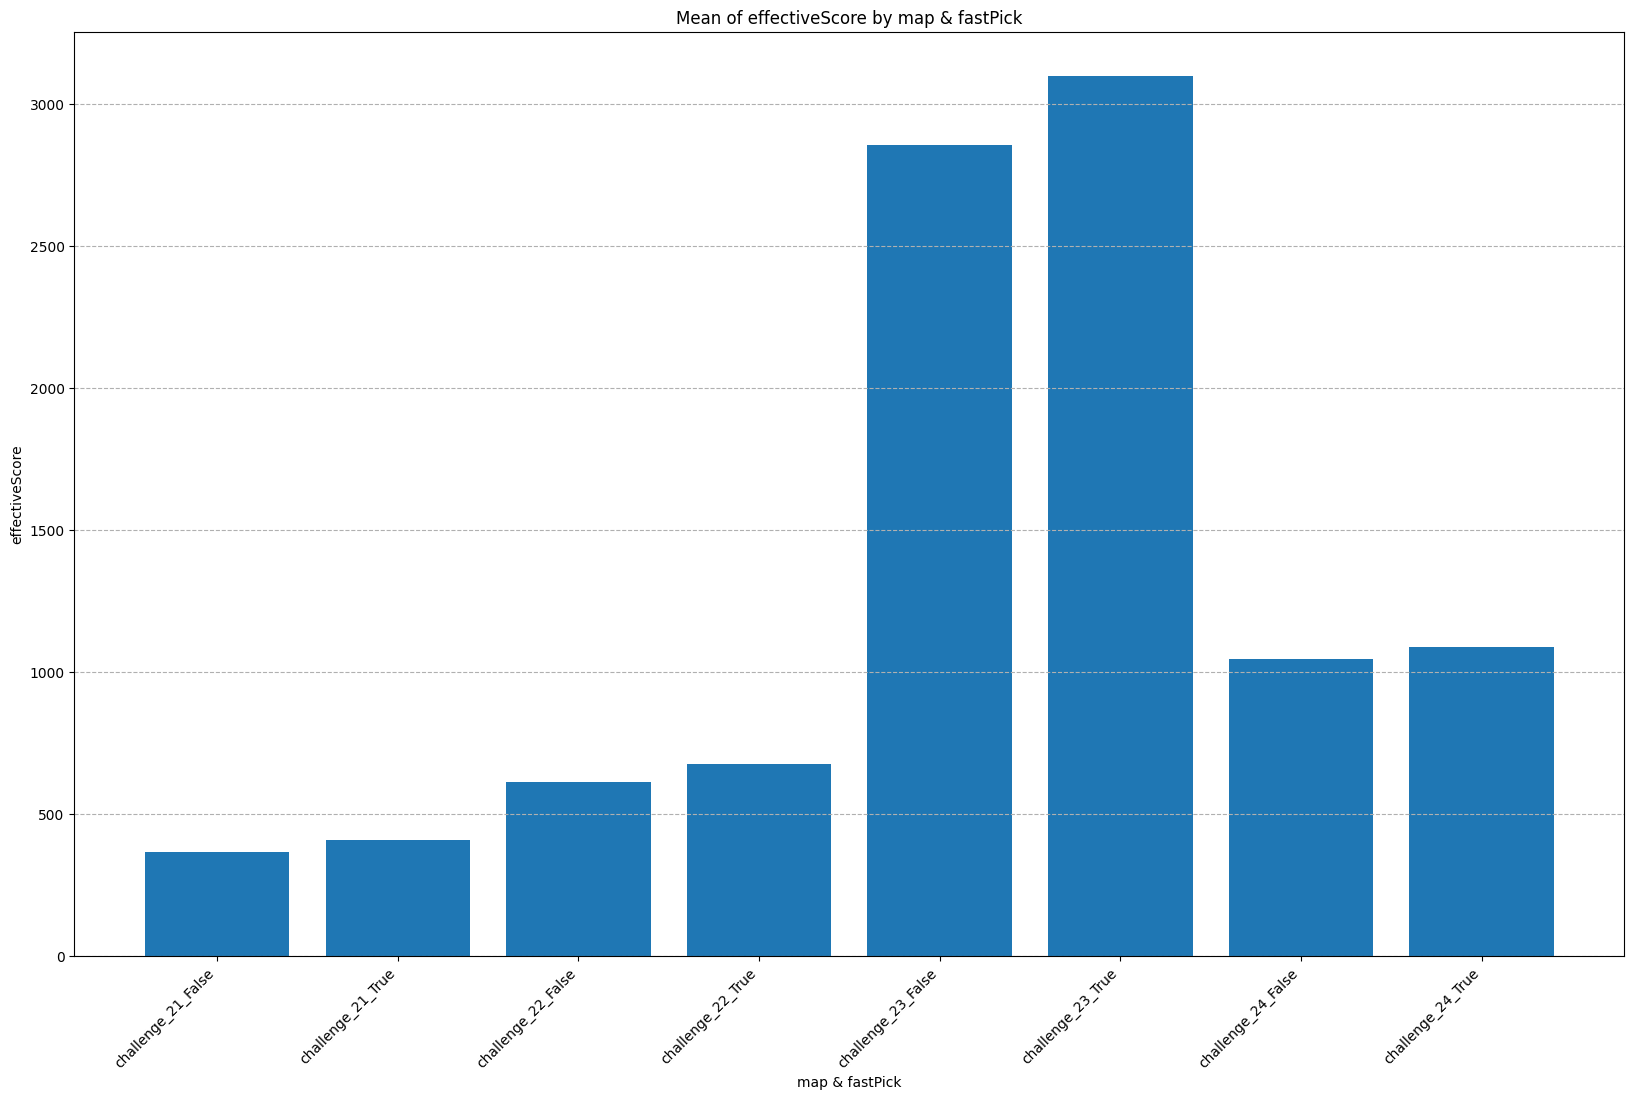

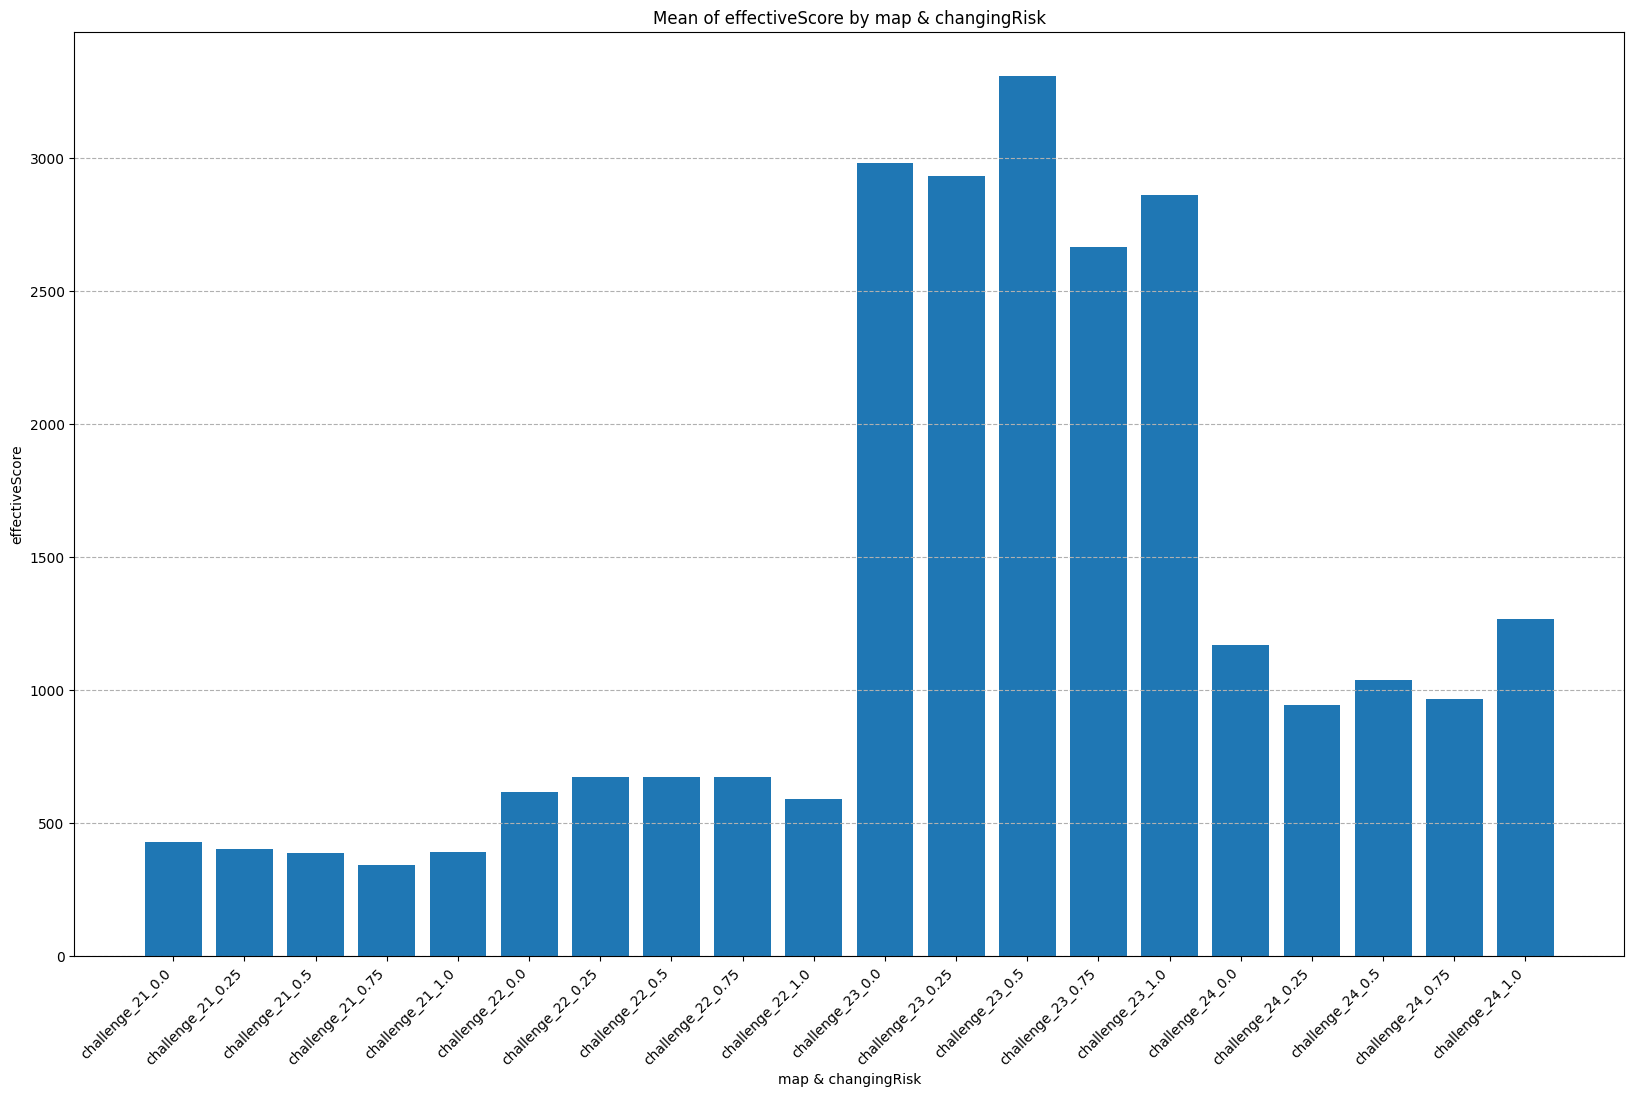

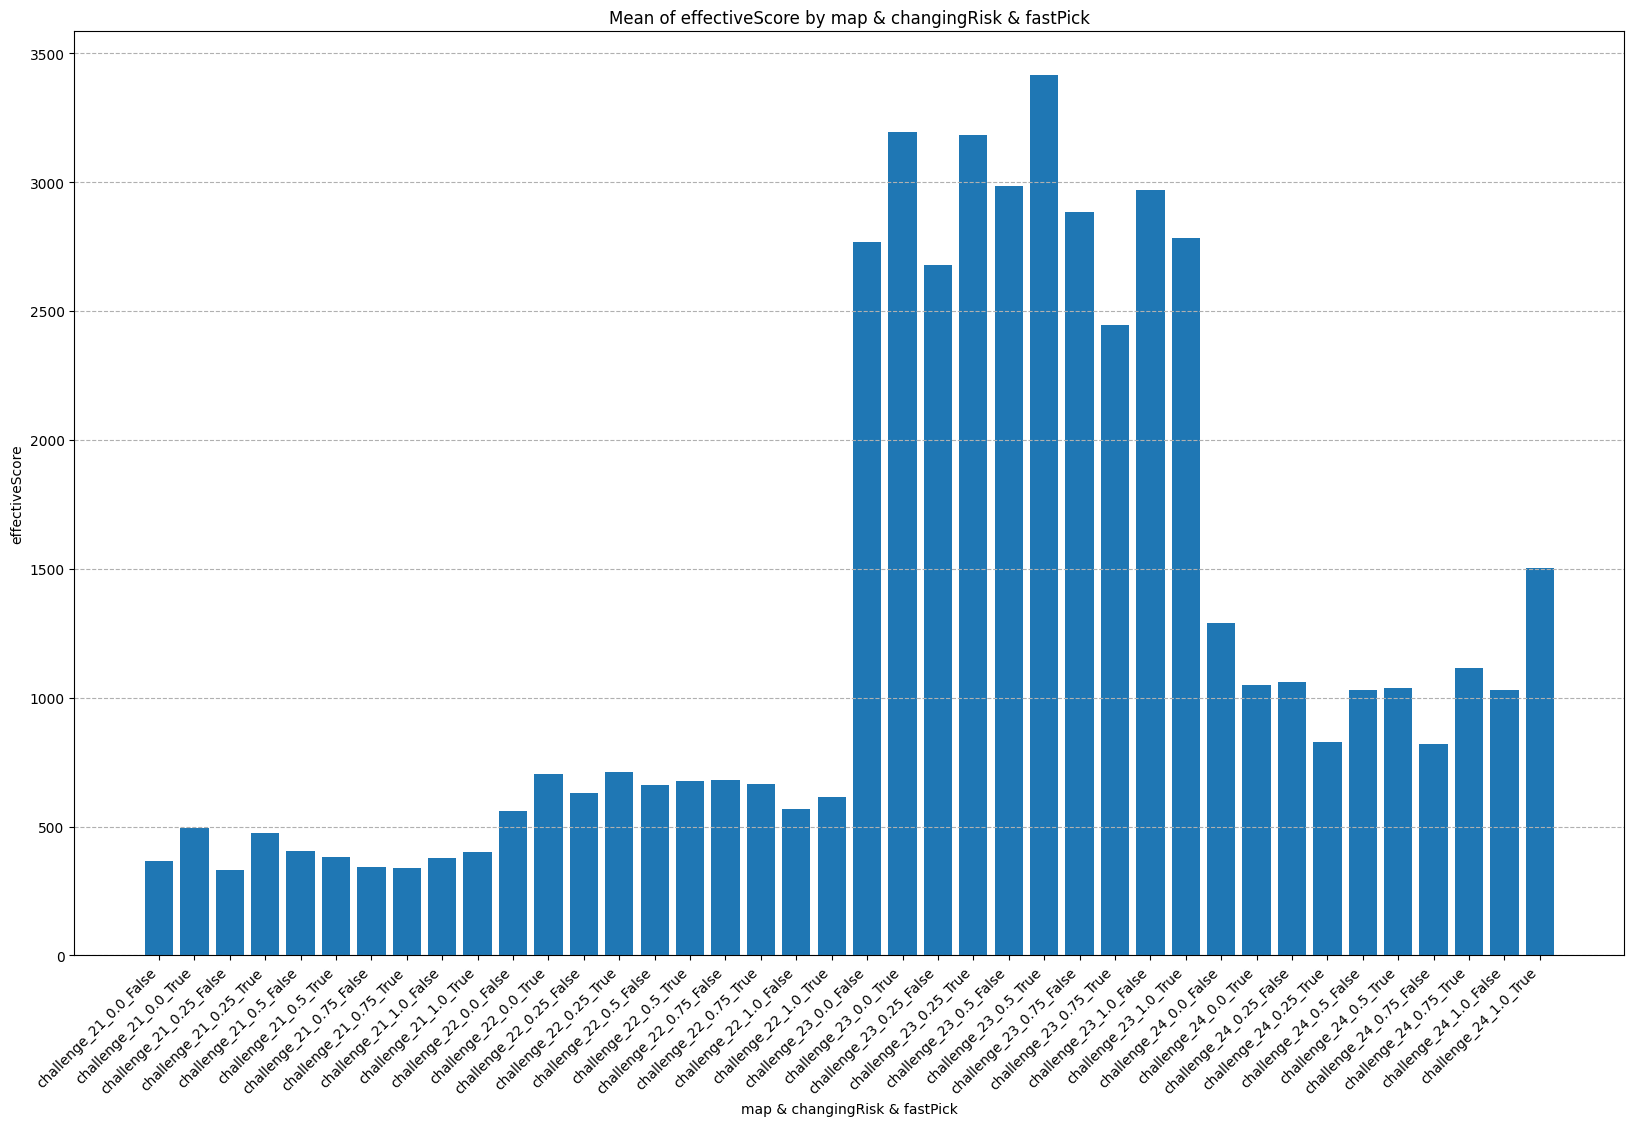

In [7]:
plot_grouped_lines(tests_bfs, 'map', 'effectiveScore')
plot_grouped_lines(tests_bfs, 'map', 'averageTimePerMove')
plot_grouped_bars(tests_bfs, ['map','fastPick'], 'pickUpActions', 'sum')
plot_grouped_bars(tests_bfs, ['map','fastPick'], 'effectiveScore', 'mean')
plot_grouped_bars(tests_bfs, ['map','changingRisk'], 'effectiveScore', 'mean')
plot_grouped_bars(tests_bfs, ['map','changingRisk','fastPick'], 'effectiveScore', 'mean')

## Single agent BFS

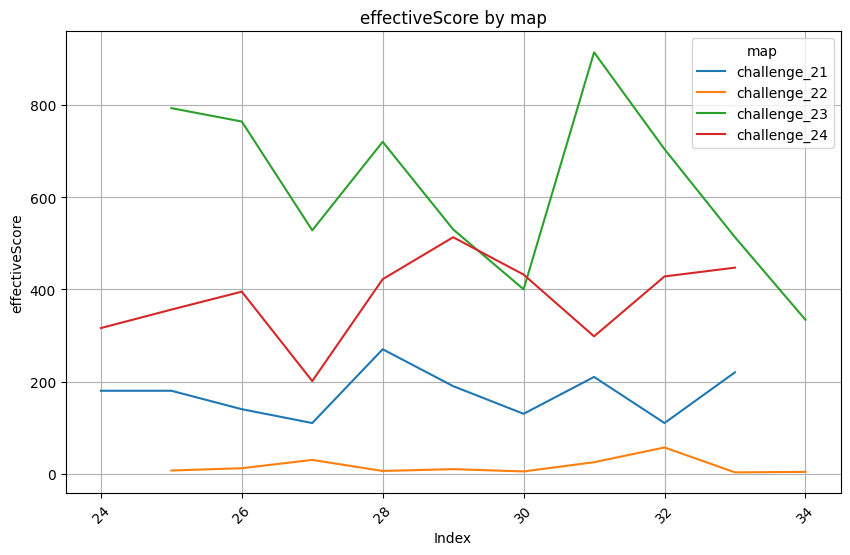

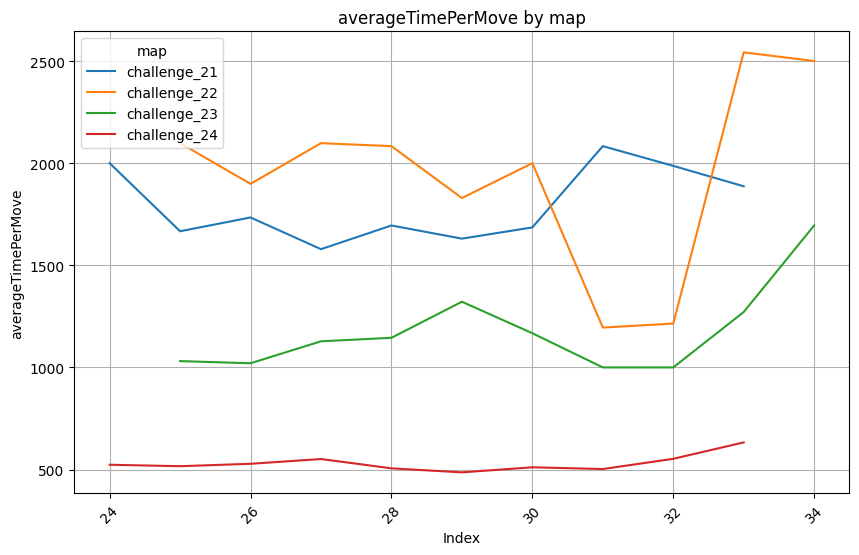

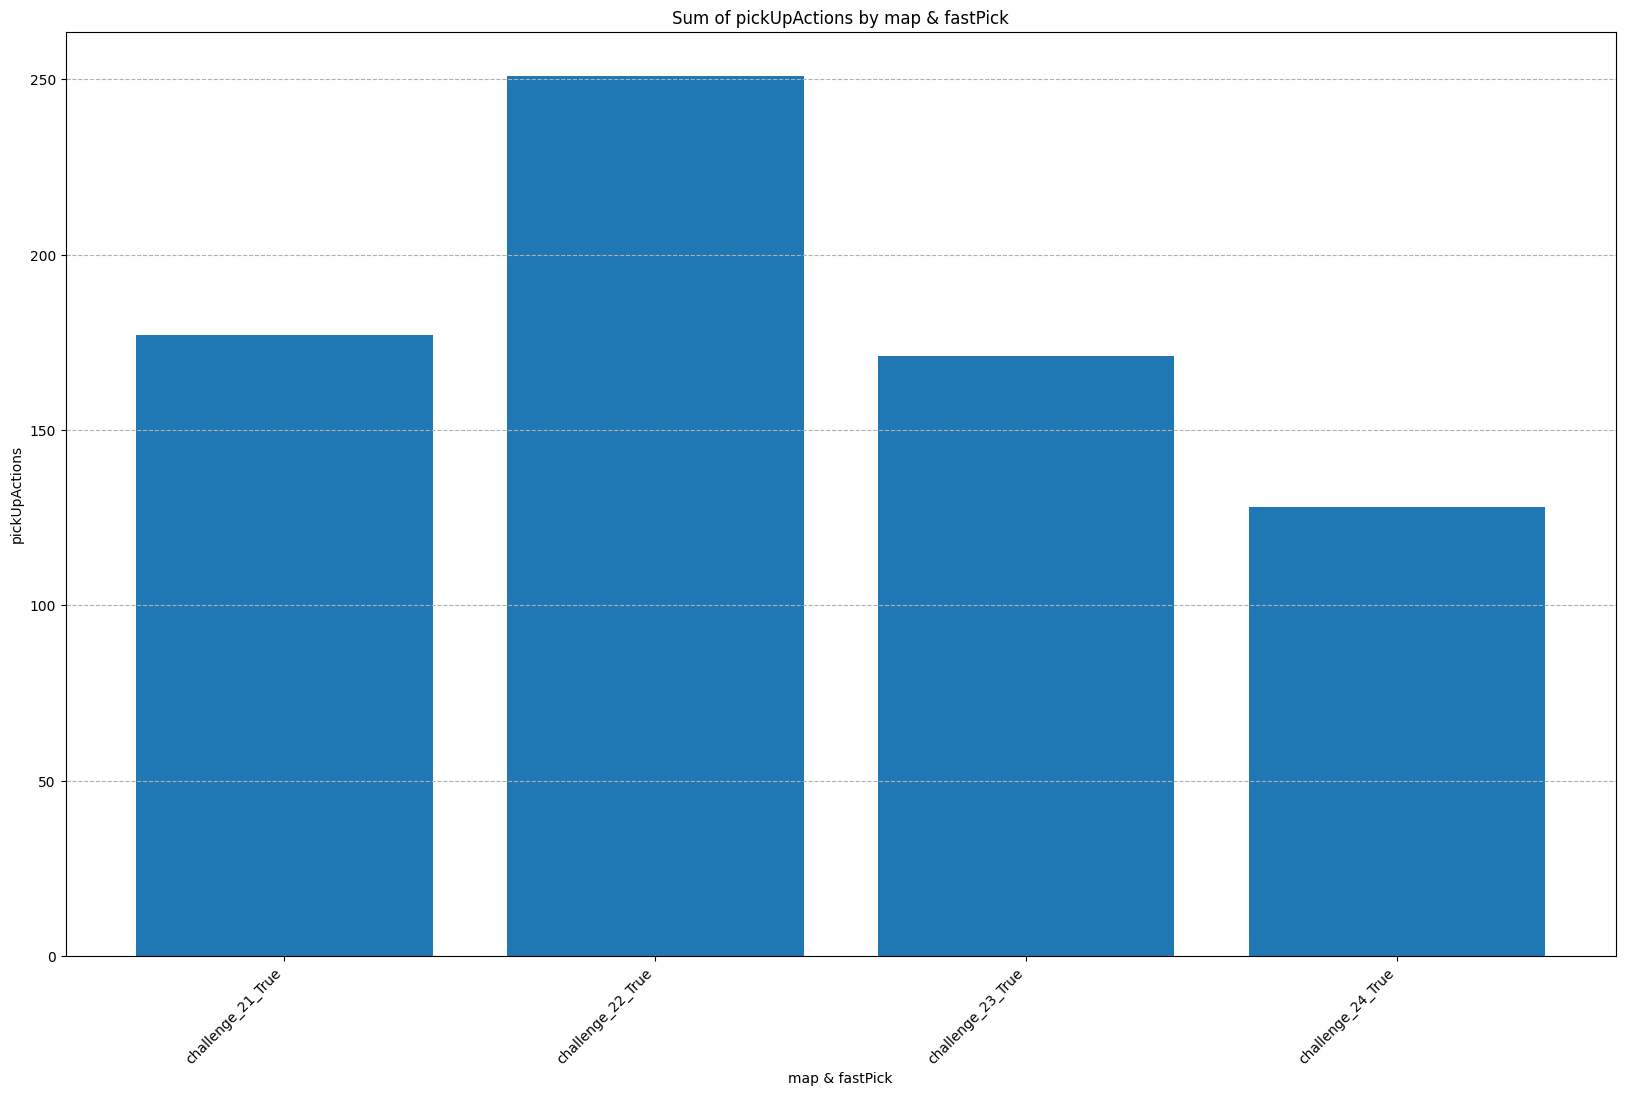

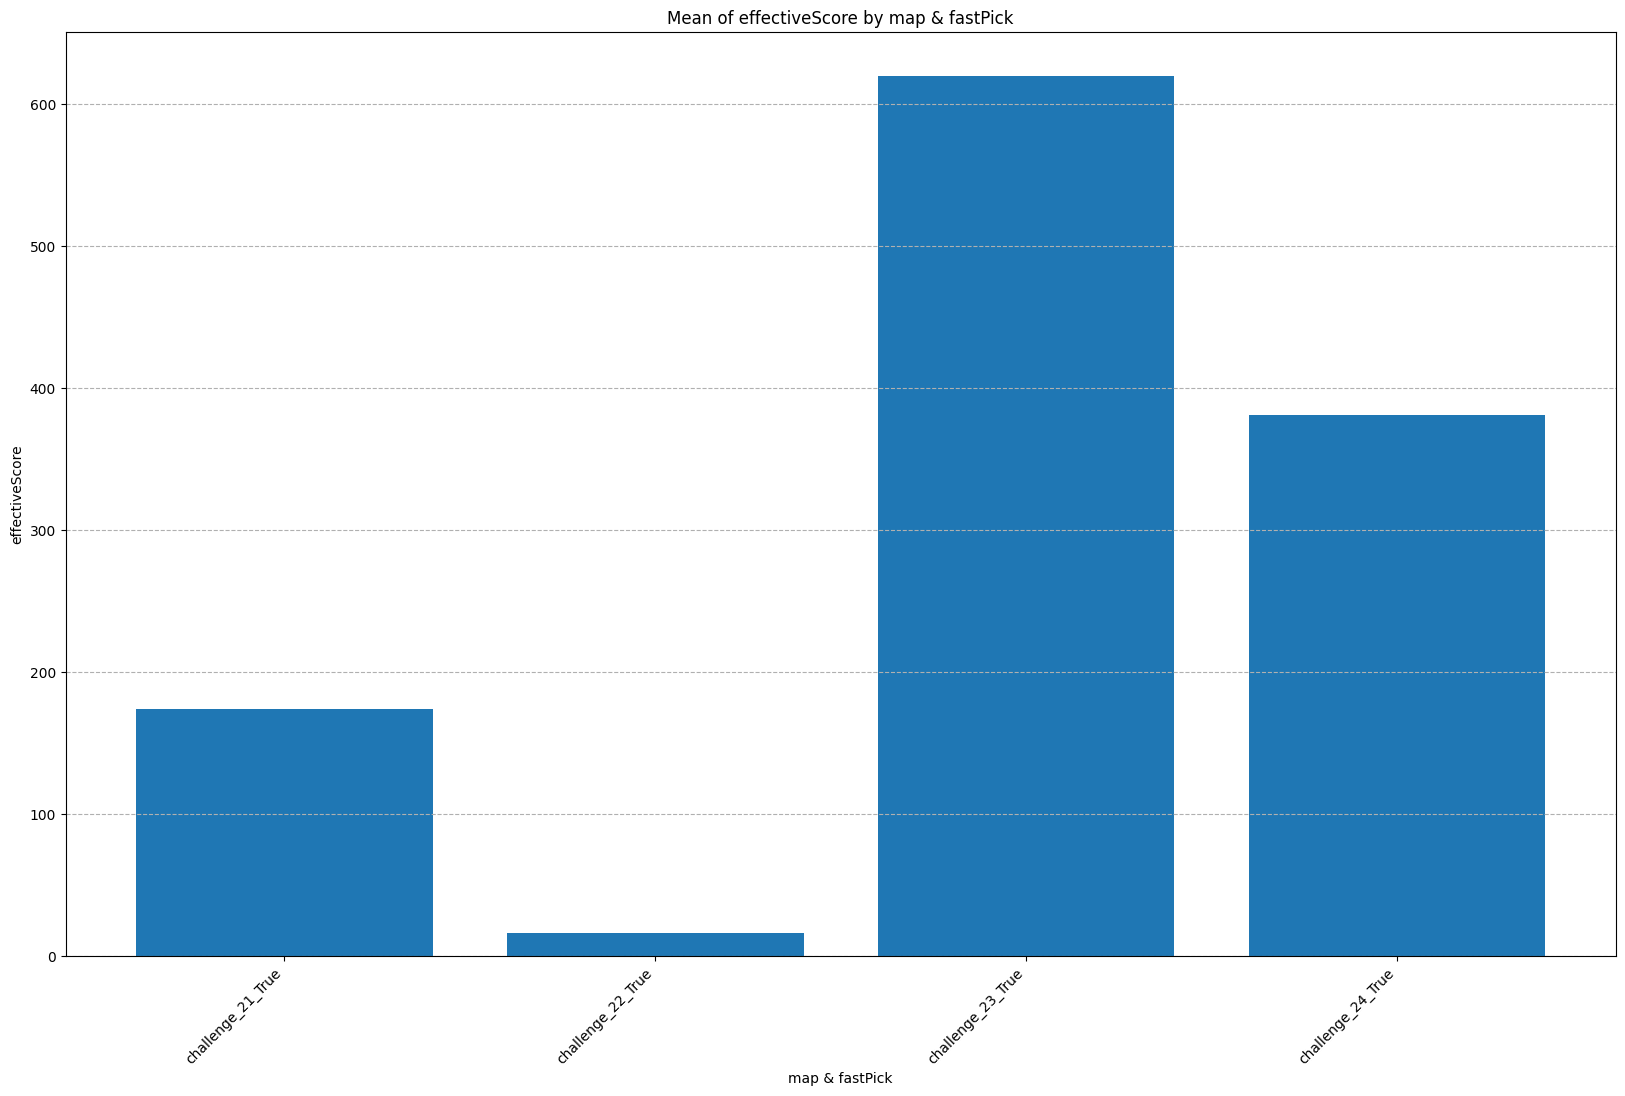

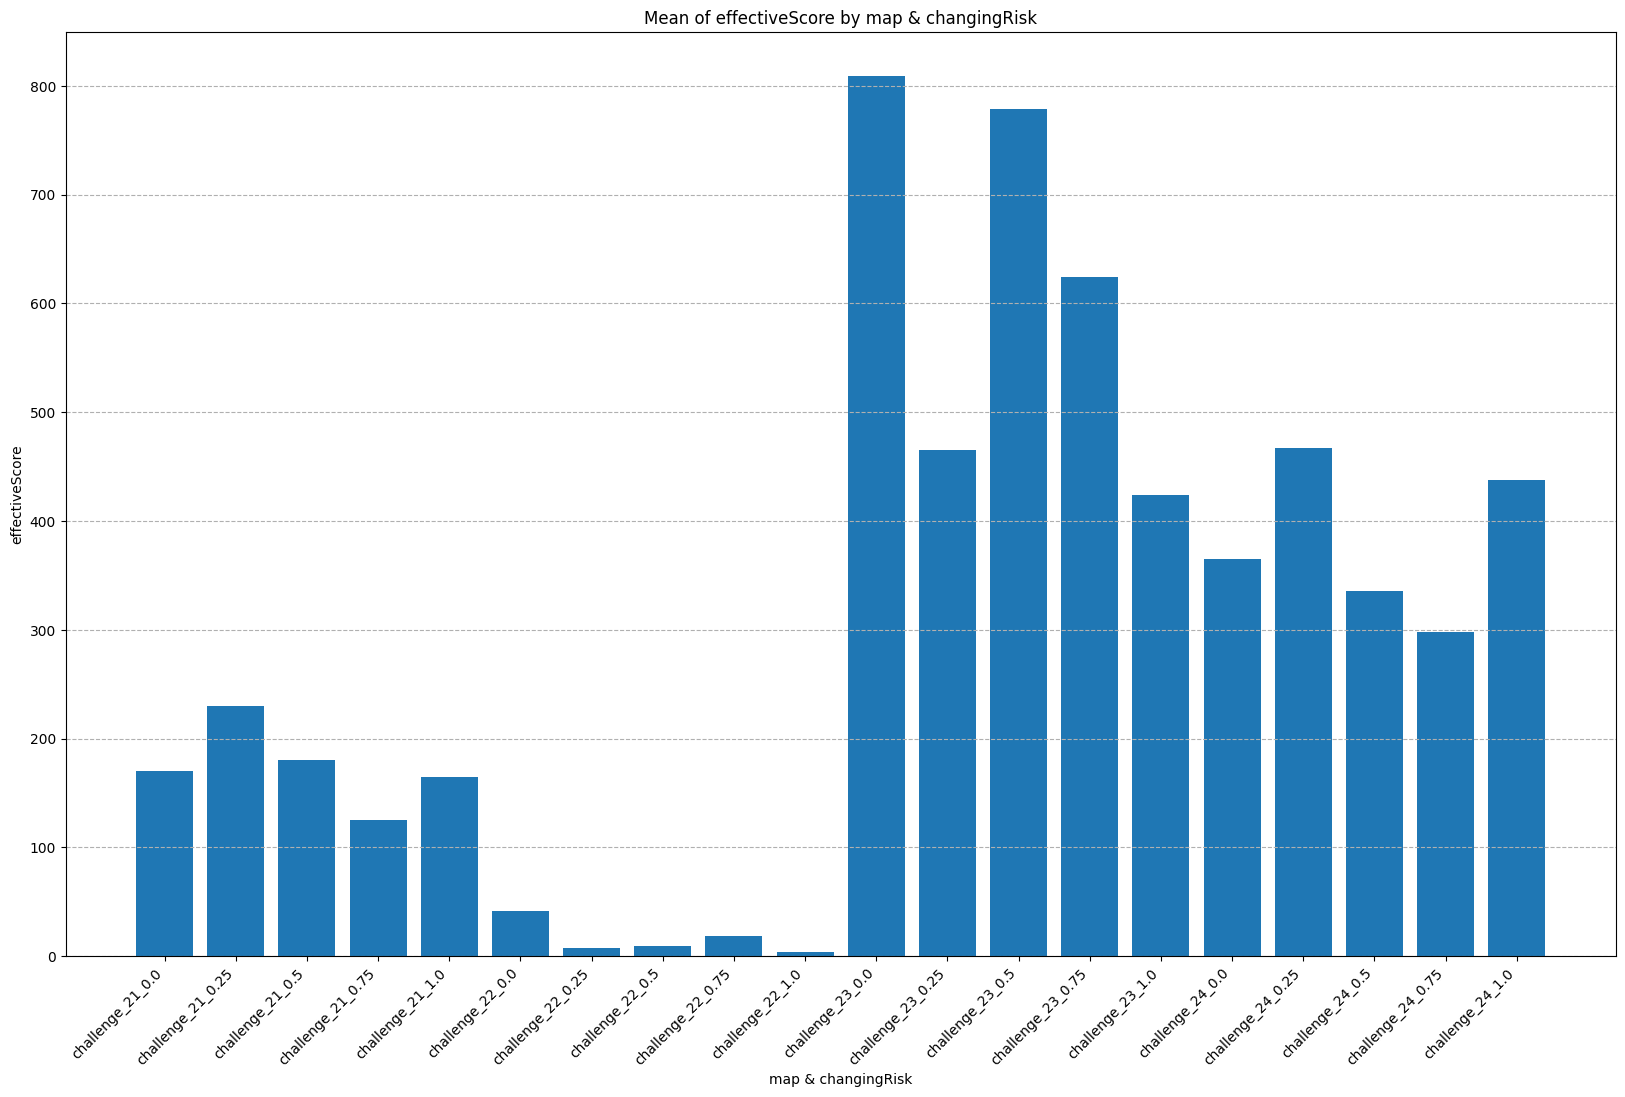

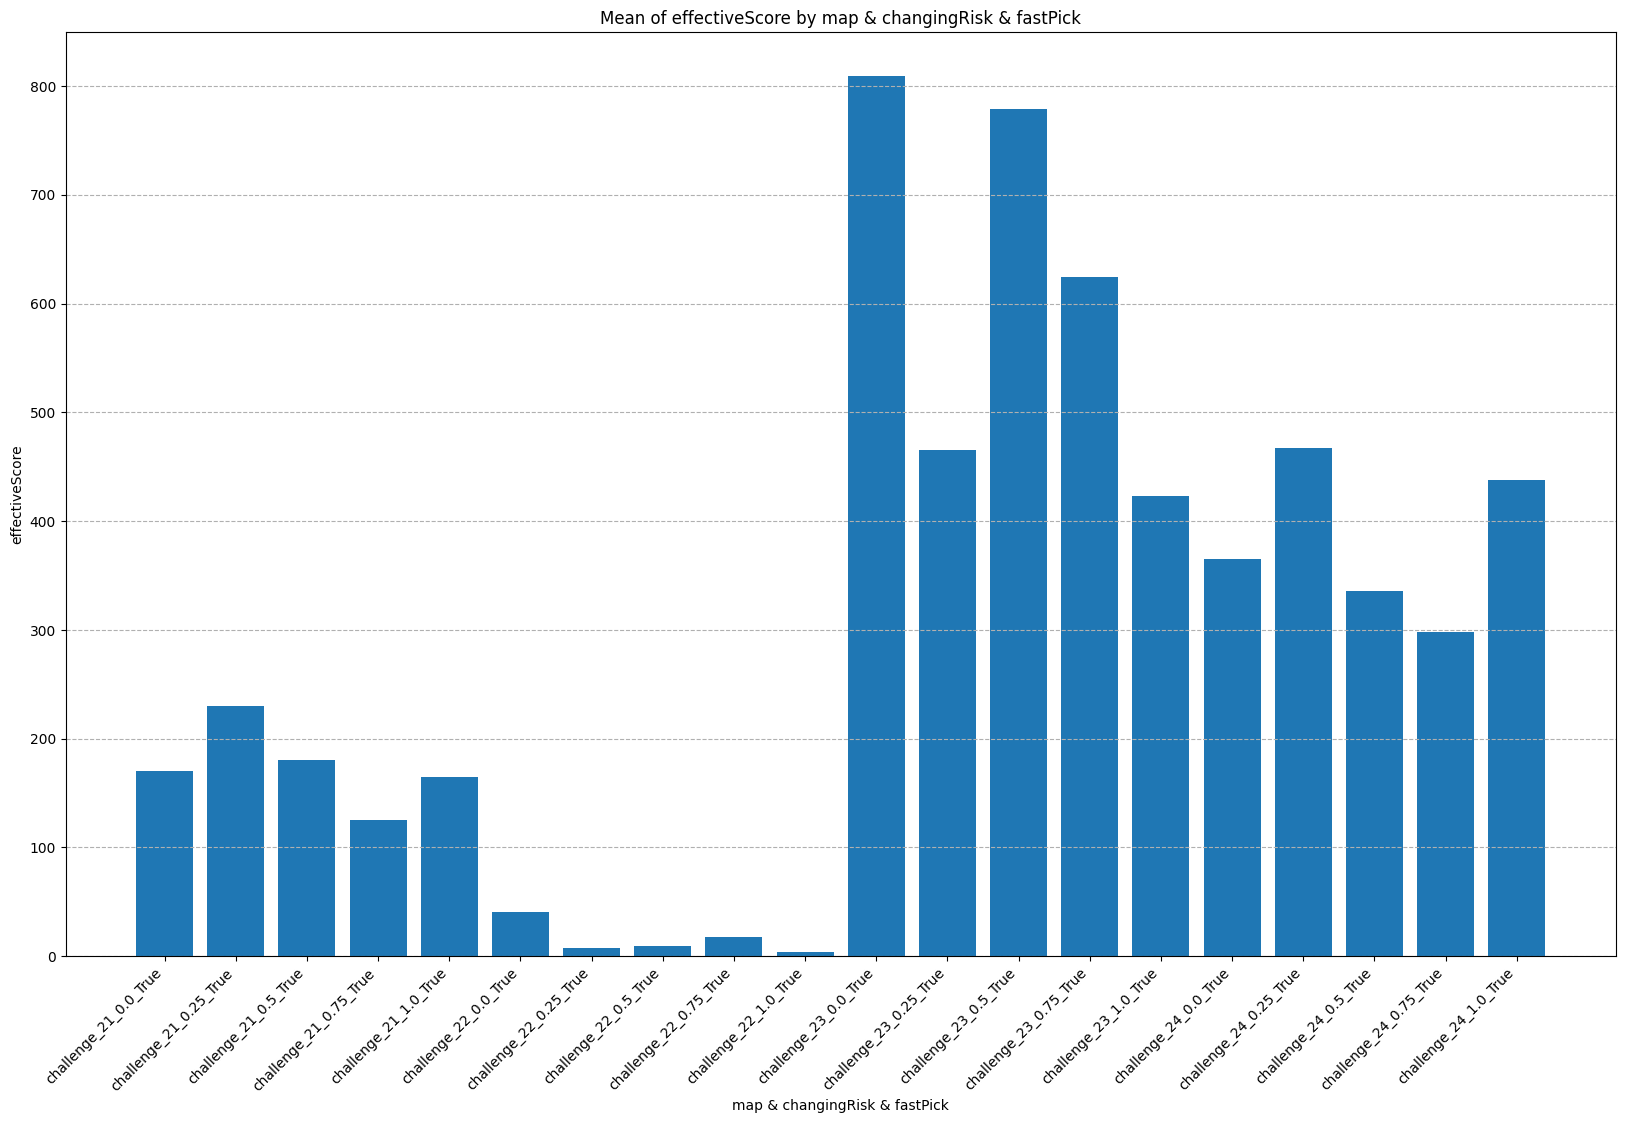

In [8]:
plot_grouped_lines(tests_pddl, 'map', 'effectiveScore')
plot_grouped_lines(tests_pddl, 'map', 'averageTimePerMove')
plot_grouped_bars(tests_pddl, ['map','fastPick'], 'pickUpActions', 'sum')
plot_grouped_bars(tests_pddl, ['map','fastPick'], 'effectiveScore', 'mean')
plot_grouped_bars(tests_pddl, ['map','changingRisk'], 'effectiveScore', 'mean')
plot_grouped_bars(tests_pddl, ['map','changingRisk','fastPick'], 'effectiveScore', 'mean')